In [1]:
from rdkit import Chem
from rdkit.Chem import RDConfig
from rdkit.Chem.QED import qed
import os
from tqdm import tqdm
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
import sys
sys.path.append('../evaluation/')
sys.path.append(os.path.join(RDConfig.RDContribDir, "SA_Score"))
import sascorer

In [3]:
from utils_eval import build_pdb_dict

In [4]:
methods = {
    'EDM': '/data/conghao001/e3_mol_design/e3_diffusion_for_molecules/generated_samples/generated_samples_SA_QED.pkl', 
    'Grum': '/data/conghao001/e3_mol_design/GruM/GruM_3D/samples/mols/GEOM_DRUGS/sdf/generated_samples_SA_QED.pkl', 
    'PP2Drug-VP-Aromatic': '/home2/conghao001/pharmacophore2drug/PP2Drug/src/lightning_logs/uncond_vp_bridge_egnn_CombinedUnconditionalDataset_2024-09-05_00_09_16.277074/ten_thousand/reconstructed_mols_aromatic_mode_SA_QED.pkl',
    # 'PP2Drug-VP-Aromatic-Optimized': '/home2/conghao001/pharmacophore2drug/PP2Drug/src/lightning_logs/uncond_vp_bridge_egnn_CombinedUnconditionalDataset_2024-09-05_00_09_16.277074/ten_thousand/reconstructed_mols_aromatic_mode_optimized_SA_QED.pkl',
    'PP2Drug-VP': '/home2/conghao001/pharmacophore2drug/PP2Drug/src/lightning_logs/uncond_vp_bridge_egnn_CombinedUnconditionalDataset_2024-09-05_00_09_16.277074/ten_thousand/reconstructed_mols_SA_QED.pkl',
    # 'PP2Drug-VP-Optimized': '/home2/conghao001/pharmacophore2drug/PP2Drug/src/lightning_logs/uncond_vp_bridge_egnn_CombinedUnconditionalDataset_2024-09-05_00_09_16.277074/ten_thousand/reconstructed_mols_optimized_SA_QED.pkl',
    'PP2Drug-VE-Aromatic': '/home2/conghao001/pharmacophore2drug/PP2Drug/src/lightning_logs/uncond_ve_bridge_egnn_CombinedUnconditionalDataset_2024-09-06_00_41_26.016199/ten_thousand/reconstructed_mols_aromatic_mode_SA_QED.pkl',
    'PP2Drug-VE': '/home2/conghao001/pharmacophore2drug/PP2Drug/src/lightning_logs/uncond_ve_bridge_egnn_CombinedUnconditionalDataset_2024-09-06_00_40_49.066238/ten_thousand/reconstructed_mols_SA_QED.pkl',
}

In [14]:
dfs = []
for method, path in methods.items():
    with open(path, 'rb') as f:
        scores = pickle.load(f)
    sa = scores['SA']
    # print(sa)
    qed = scores['QED']
    assert len(sa) == len(qed)
    dist_type = [method for _ in sa.keys()]
    df = pd.DataFrame([sa.values(), qed.values(), dist_type]).T
    df.columns = ['sa_scores', 'qed_scores', 'Model']
    dfs.append(df)

In [15]:
sa_qed_df = pd.concat(dfs)
sa_qed_df

,sa_scores,qed_scores,Model
0,6.590523,0.39808,EDM
1,6.602499,0.390324,EDM
2,6.73437,0.459664,EDM
3,6.595893,0.367578,EDM
4,6.487727,0.494898,EDM
...,...,...,...
9658,3.996843,0.373187,PP2Drug-VE
9659,2.197649,0.380939,PP2Drug-VE
9660,6.203725,0.491652,PP2Drug-VE
9661,6.361943,0.476383,PP2Drug-VE


<Figure size 800x1000 with 0 Axes>

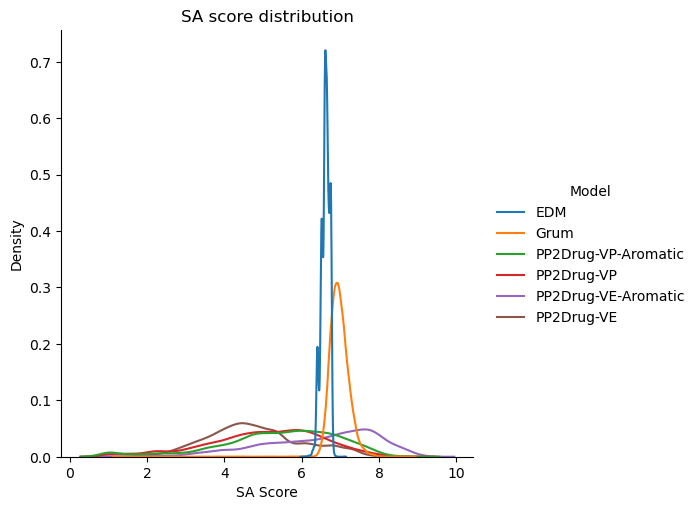

In [23]:
plt.figure(figsize=(8, 10))

sns.displot(sa_qed_df ,x = 'sa_scores',  hue="Model", kind = 'kde')
plt.title('SA score distribution')
plt.xlabel('SA Score')
# plt.legend(title='Model')
plt.savefig('sa_dist.png', dpi=400, bbox_inches='tight')
plt.show()

<Figure size 800x1000 with 0 Axes>

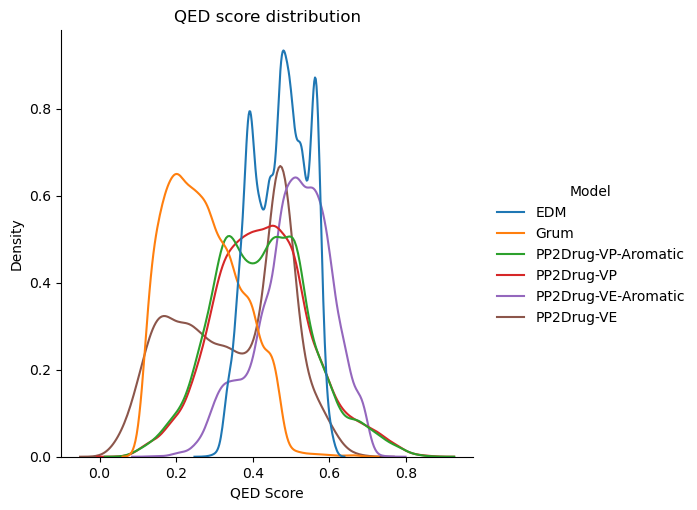

In [24]:
plt.figure(figsize=(8, 10))

sns.displot(sa_qed_df ,x = 'qed_scores',  hue="Model", kind = 'kde')
plt.title('QED score distribution')
plt.xlabel('QED Score')
# plt.legend()
plt.savefig('qed_dist.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
bridge_type = 'vp'

# egnn
# fixed point init
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-31_14_11_45.077216'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-30_23_27_53.688104'
# Gaussian noise init
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-06-17_23_04_23.779433'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-06-17_23_06_28.209248'

# transformer
# root_path = '../lightning_logs/vp_bridge_CombinedSparseGraphDataset_2024-06-01_21_36_34.208973'
# root_path = '../lightning_logs/vp_bridge_CombinedSparseGraphDataset_2024-05-31_23_42_37.443630'

# only basic

# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-19_14_29_28.164795'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-19_14_29_44.297462'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-30_02_43_56.802640'

# basic + aromatic

# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-20_02_24_30.913781'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-20_13_18_12.746286'

# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-21_23_58_36.562980'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-30_02_43_19.450576'

# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-31_22_40_53.679692'

# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-31_22_40_53.679692'    # 0.97 0.32
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-08-01_11_35_53.861210'    # 0.88 0.29

# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-31_22_41_26.883181'

# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-08-19_13_30_50.133260'
root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-08-19_21_05_04.140916'



In [12]:
# bridge_type = 've'

# root_path = ''

In [28]:
aromatic = True
optimization = True

gen_path = os.path.join(root_path, 'reconstructed_mols')
gen_path = gen_path + '_aromatic_mode' if aromatic else gen_path
gen_path = gen_path + '_optimized' if optimization else gen_path

In [22]:
# root_path = '../evaluation/ligand_based'
root_path = '../evaluation/structure_based'
bridge_type = 'vp'

# ligand_name = '3hfg_A_rec_3hfg_17r_lig_tt_min_0'
# ligand_name = '3ey4_C_rec_5pgu_8k4_lig_tt_min_0'  # 0.11 0.10
# ligand_name = '5ni2_A_rec_5aen_dp8_lig_tt_min_0'
# ligand_name = '3fu5_A_rec_5ni6_dj3_lig_tt_min_0'
# ligand_name = '4yyz_B_rec_2ilt_nn1_lig_tt_min_0'  # 0.16 0.20 
# ligand_name = '4bnn_A_rec_4bnm_tcu_lig_tt_min_0'
# ligand_name = '4yvx_A_rec_1s2a_imn_lig_tt_min_0'
# ligand_name = '3czr_B_rec_4bb5_hd2_lig_tt_min_0'
# ligand_name = '3czr_A_rec_2ilt_nn1_lig_tt_min_0'
# ligand_name = '4b84_A_rec_4btl_5gz_lig_tt_min_0'
# ligand_name = '3fue_A_rec_3ftv_11x_lig_tt_min_0'  # 0.04 0.05
# ligand_name = '4bnk_B_rec_4d44_ja3_lig_tt_min_0'  # 0.26 0.27
# ligand_name = '3qqp_B_rec_4k1l_sff_lig_tt_min_0'
# ligand_name = '4wdu_A_rec_3r94_flr_lig_tt_min_0'  # 0.37 0.27
# ligand_name = '4alj_A_rec_4bnf_pv4_lig_tt_docked_0'  # 0.24 0.24
# ligand_name = '1ejj_A_rec_1o99_2pg_lig_tt_docked_0'
# ligand_name = '4h96_B_rec_4h95_06u_lig_tt_min_0'  # 0.40 0.42
# ligand_name = '2oa6_D_rec_4kvi_1sv_lig_tt_min_0'  # 0.36 0.41
# ligand_name = '4hx5_B_rec_3bzu_a21_lig_tt_min_0'
# ligand_name = '5pgy_D_rec_3bzu_a21_lig_tt_min_0'
# ligand_name = '5pgv_A_rec_3bzu_a21_lig_tt_min_0'
# ligand_name = '4kux_B_rec_4kvw_jf4_lig_tt_min_0'  # 0.61 0.63
# ligand_name = '4bnk_B_rec_4bnl_w1g_lig_tt_min_0'
# ligand_name = '4b82_B_rec_4ara_c56_lig_tt_min_0'  # 0.42 0.53
# ligand_name = '4pm0_A_rec_4y2b_epk_lig_tt_min_0'
# ligand_name = '4ms6_A_rec_3fuh_5h1_lig_tt_min_0'  # 0.02 0.02
# ligand_name = '5ivg_B_rec_4kvy_jf1_lig_tt_docked_9'  # 0.61 0.69
ligand_name = '3r8h_A_rec_3r8h_zom_lig_tt_min_0'
# ligand_name = '1aoe_A_rec_3qlr_qlr_lig_tt_docked_4'  # 0.19 0.28
# ligand_name = '2ilt_A_rec_3ey4_352_lig_tt_min_0'  # 0.70 0.71
# ligand_name = '2g1q_A_rec_1x88_nat_lig_tt_min_0'  # 0.59 0.59
# ligand_name = '5imp_B_rec_4kwd_jf2_lig_tt_min_0'  # 0.54 0.55
# ligand_name = '4d45_A_rec_4ali_tcl_lig_tt_min_0'  # 0.57 0.52
# ligand_name = '5ivg_B_rec_4kvw_jf4_lig_tt_min_0'
# ligand_name = '2rbe_C_rec_3byz_h11_lig_tt_min_0'
# ligand_name = '2whr_A_rec_3zlv_hi6_lig_tt_min_0'
# ligand_name = '4hmn_A_rec_3ufy_npx_lig_tt_min_0'
# ligand_name = '4h7c_A_rec_3r6i_jms_lig_tt_min_0'

aromatic = True

gen_path = os.path.join(root_path, bridge_type, ligand_name, 'aromatic' if aromatic else 'basic')

In [29]:
raw_data_path = '../../data/cleaned_crossdocked_data/raw'
pdb_dict, pdb_rev_dict = build_pdb_dict(raw_data_path)

In [30]:
def get_mols(gen_path, ligand_name=None, raw_data_path=raw_data_path):
    gen_mols, ref_mols = {}, {}
    for file in tqdm(os.listdir(gen_path)):
        ligand = file.split('.')[0]
        # ref_folder = pdb_rev_dict[ligand_name+'.sdf']
        ref_folder = pdb_rev_dict[file]

        gen_m = Chem.MolFromMolFile(os.path.join(gen_path, file))
        # ref_m = Chem.MolFromMolFile(os.path.join(raw_data_path, ref_folder, ligand_name+'.sdf'))
        ref_m = Chem.MolFromMolFile(os.path.join(raw_data_path, ref_folder, file))
        if gen_m == None or ref_m == None:
            continue
            
        gen_mols[ligand] = gen_m
        ref_mols[ligand] = ref_m

    return gen_mols, ref_mols

In [31]:
gen_mols, ref_mols = get_mols(gen_path, ligand_name=None)
# gen_mols, ref_mols = get_mols(gen_path, ligand_name=ligand_name)

100%|█████████████████████████████████████████████████████████████████████| 26937/26937 [01:20<00:00, 334.13it/s]


In [32]:
len(gen_mols), len(ref_mols)

(26937, 26937)

In [33]:
def compute_sa_score(mols, threshold = 5.5):
    
    sa_scores = [sascorer.calculateScore(mol) if mol!=None else 10 for mol in tqdm(mols)]
    pct_easily_synthesized = len([score for score in sa_scores if score <= threshold])/len(sa_scores)
    return sa_scores, pct_easily_synthesized

In [34]:
sa_scores, pct_easily_synthesized = compute_sa_score(gen_mols.values())
pct_easily_synthesized

100%|████████████████████████████████████████████████████████████████████| 26937/26937 [00:05<00:00, 4938.15it/s]


0.7819356275754539

In [35]:
ref_sa_scores, ref_pct_easily_synthesized = compute_sa_score(ref_mols.values())

100%|████████████████████████████████████████████████████████████████████| 26937/26937 [00:06<00:00, 4173.68it/s]


In [36]:
ref_pct_easily_synthesized

0.9892341389167316

In [37]:
np.mean(sa_scores), np.mean(ref_sa_scores)

(4.857652358107705, 2.7877407795271663)

In [38]:
qed_scores = [qed(mol) for mol in tqdm(list(gen_mols.values()))]
ref_qed_scores = [qed(mol) for mol in tqdm(ref_mols.values())]
qed_scores, ref_qed_scores

100%|████████████████████████████████████████████████████████████████████| 26937/26937 [00:26<00:00, 1004.18it/s]


([0.25581392032532496,
  0.5084094298910218,
  0.32321324436547655,
  0.4541538827385624,
  0.09869562853531826,
  0.4301665027690878,
  0.4063379244355816,
  0.25762589537745334,
  0.5006530213540101,
  0.312642098065464,
  0.07907836396655048,
  0.6441514822318356,
  0.06740827834242137,
  0.13196416954608914,
  0.17313396429247083,
  0.25150846292522927,
  0.07788182074265845,
  0.4667771845930254,
  0.43007002033469494,
  0.3002715971266244,
  0.353882530771982,
  0.416026612027673,
  0.23715687628177295,
  0.4295428090698125,
  0.4266150517738931,
  0.2432806040948993,
  0.6975933708111743,
  0.3438071834089974,
  0.28114908103611713,
  0.32716684599478774,
  0.0780282580188946,
  0.5582561927095648,
  0.12475913412716753,
  0.19847443359629294,
  0.43307030405538527,
  0.5677499303777641,
  0.3022920046386802,
  0.5541249877339248,
  0.5235366862450793,
  0.7642198546129192,
  0.037645816360866495,
  0.10574968967535114,
  0.04578234883621851,
  0.12102222718567231,
  0.153725327

In [110]:
np.mean(qed_scores), np.mean(ref_qed_scores)

(0.4065414630552253, 0.881301217150519)

In [111]:
for k in gen_mols.keys():
    mol = gen_mols[k]
    ref_mol = ref_mols[k]
    if mol != None:
        sa_score = sascorer.calculateScore(mol)
    else:
        sa_score = 10

    qed_score = qed(mol)

    ref_sa_score = sascorer.calculateScore(ref_mol)
    ref_qed_score = qed(ref_mol)